# Projet : Reflector imaging from ambient noise signals

In [26]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.integrate import quad

In [27]:
def simulated_sampling(N = 200):
    ys = np.vstack((np.random.uniform(-50,50, N),np.random.uniform(-10,10, N),np.random.uniform(185,200, N)))
    return ys.T

def receivers_sampling(n = 5):
    x = np.zeros((n,3))
    x[:,0] = np.arange(n)* 7.5 - 30
    x[:,2] = 100 * np.ones(n)
    return x

### 2) Preliminaries 

In [28]:
c0 = 1 
xr = -5 
yr = 0
zr = np.array([-5,0,65])
sigmar = 1e-3

In [29]:
y = simulated_sampling()
x = receivers_sampling()

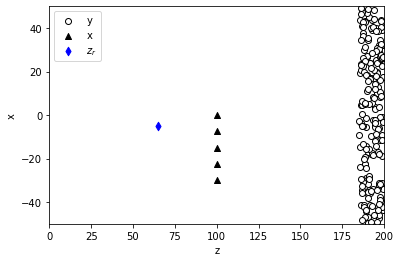

In [30]:
plt.scatter(y[:,2], y[:,0], marker ='o', color = 'white', edgecolors = 'black', label = 'y')
plt.scatter(x[:,2], x[:,0], marker = '^', color ='black', label ='x')
plt.scatter(zr[2], zr[0], marker = 'd', color = 'b', label = r'$z_r$')
plt.xlabel("z")
plt.xlim(0,200)
plt.ylim(-50,50)
plt.ylabel("x")
plt.legend()
plt.show()

### 4) Questions 

In [43]:
def power_spectral_density(omega):
    return np.exp(-np.power(omega,2))

def homogeneous_green_function(omega,x,y):
    if len(x.shape)==1 and len(y.shape)==1 :
        z = np.linalg.norm(x-y)
    else : 
        z = np.linalg.norm(x-y, axis = 1)
    return 1/(4*np.pi*z)*np.exp(1j * omega * z /c0)

def green_function(omega, x, y):
    G = homogeneous_green_function
    return G(omega,x,y) + sigmar * np.power(omega,2)*G(omega,x,zr)*G(omega,zr,y)


def expectation_cross_correlation(tau, x1, x2,y, a = -10, b = 10, n = 1000):    
    omega = np.linspace(a, b, n).reshape(-1,1)
    G_hat_G = np.conj(green_function(omega, x1, y)) * green_function(omega, x2, y)
    C_N = np.dot(power_spectral_density(omega).T,G_hat_G.mean(1))*np.exp(-1j*omega*tau)
    
    # Intégrale de Riemann
    C_N = (b-a)*C_N.mean(0)
    return C_N/(2*np.pi)

/Users/macrafa/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


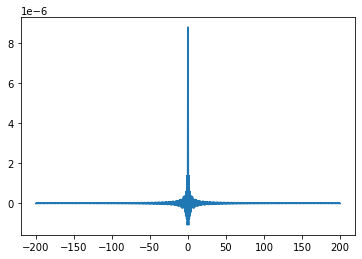

In [44]:
tau = np.linspace(-200,200,1000)

f = expectation_cross_correlation(tau,x[4],x[0],y)
plt.plot(tau, f)
plt.show()

In [45]:
window_size = 20
line = np.arange(-window_size//2,window_size//2)
y_S = zr + [0, 0, 1] * line.reshape(-1,1) + [1, 0, 0] * line.reshape(-1,1,1)

In [46]:
y_S.shape

(20, 20, 3)

In [97]:
def KM_images(y_S, x, y):
    L = x.shape[0]
    a = y_S.shape[0]
    
    image = np.zeros((a,a))
    for s in range(a):
        I_N = 0
        for j in range(L):
            for l in range(L):
                tau1 = np.linalg.norm(x[j]-y_S[s,:], axis = 1)
                tau2 = np.linalg.norm(x[l]-y_S[s,:], axis = 1)
                I_N += expectation_cross_correlation(tau1 + tau2, x[j],x[l],y)
                #I_N += C_N(tau1 + tau2, x[j], x[l], y, c0, zr, sigmar).real
        image[s,:] = I_N
    return image

<ipython-input-97-6c1baabe23b8>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  image[s,:] = I_N


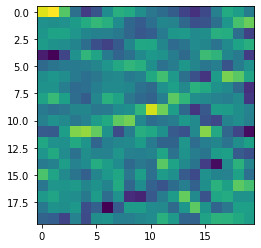

In [98]:
Image = KM_images(y_S, x, y)
plt.imshow(Image)
plt.show()

#### Resolution 

In [11]:
def resolution(img):
    img = np.power(img, 2)
    R = np.max(img)/np.mean(img)
    return R

In [12]:
R = resolution(Image)
print("Resolution de l'image KM de I_N : " + str(R))

Resolution de l'image KM de I_N : 13.07191402640781


#### 2.a

In [13]:
tau = np.linspace(-150,150,1000)



In [16]:
def empirical_cross_correlation(tau, T, x1, x2, y, a = -10, b = 10, n = 1000): 
    return 0